# 準備資料

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

pandas 讀取資料 ( csv 格式)

In [0]:
california_housing_dataframe = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv',sep=',')

資料隨機化，避免影響隨機梯度下降法的效果；median_house_value調整成千為單位，增加運算效率

In [6]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000.0

california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12493,-121.6,39.0,36.0,1826.0,329.0,1068.0,318.0,2.0,0.1
15460,-122.3,37.9,39.0,2955.0,696.0,1417.0,682.0,2.8,0.2
11360,-121.2,37.8,4.0,58.0,29.0,79.0,29.0,3.4,0.1
13536,-122.0,37.0,23.0,4324.0,1034.0,1844.0,875.0,3.1,0.3
9819,-119.7,36.2,35.0,2011.0,349.0,970.0,300.0,2.4,0.1


In [8]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,0.2
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,0.1
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,0.1
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,0.2
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,0.3
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,0.5


# 建立模型

將 total_rooms 作為 feature ，預測 median_house_value ，每個城市街區會有相對應的房間總數。

使用 TensorFlow Estimator API 提供的 LinearRegressor 接口。

### 第一步：定義特徵與特徵列

特徵主要包含分類/數值兩種資料，這次使用數值。

TensorFlow 使用 feature column 儲存對特徵資料的描述。

In [0]:
# Define the input feature: total rooms.
my_feature = california_housing_dataframe[['total_rooms']]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

### 第二步：定義目標

即是 median_house_value ，可從 california_housing_dataframe 提取。

In [0]:
# Define the label.
targets = california_housing_dataframe['median_house_value']

### 第三步：配置LinearRegressor

使用 GradientDescentOptimizer 訓練模型(他會實現SGD)，參數 learning_rate 可控制梯度步長的大小。

使用 clip_gradients_by_norm 將梯度剪裁優化，確保梯度大小在訓練其不會變得太大，導致梯度下降失敗。

In [0]:
# Use gradient descent as optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### 第四步：定義輸入函數

將 pandas 特徵資料轉成 numpy 數據字典，把資料分成 batch_size 大小的多筆資料，在依週期數 (num_epochs) 重複進行。

若 shuffle 設為 True，資料在訓練期間以隨機方式傳遞到模型。buffer_size 參數指定 shuffle 抽樣資料及的大小。

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/reporting.
    ds = Dataset.from_tensor_slices((features, targets)) #warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### 第五步：訓練模型

將 my_input_fn 封裝在 lambda 中，以便將 my_feqature 和 target 作為參數傳入。

訓練100步。

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

###第六步：評估模型

訓練誤差可衡量模型與訓練資料的你和狀況，但不能衡量泛化到新資料的效果。

In [34]:
# Create an inpput function for predictions.
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regress to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a numpy array, so can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squarred Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 0.028
Root Mean Squared Error (on training data): 0.168


MSE 較難解讀，故通常看到的是 RMSE。

RMSE 有個特性：其可與元目標相同的規膜下解讀。

In [35]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 0.015
Max. Median House Value: 0.500
Difference between Min. and Max.: 0.485
Root Mean Squared Error: 0.168


將獲得均勻分布的隨機樣本繪製散點圖。

In [0]:
sample = california_housing_dataframe.sample(n=300)

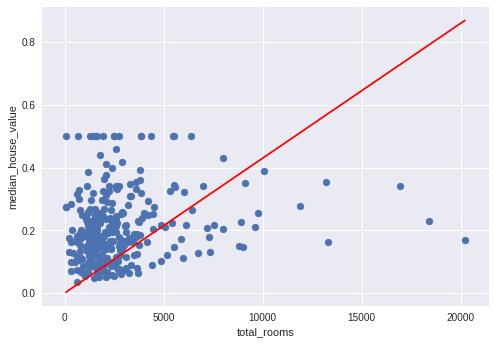

In [37]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

是否可以找到更好的參數來降低RMSE？